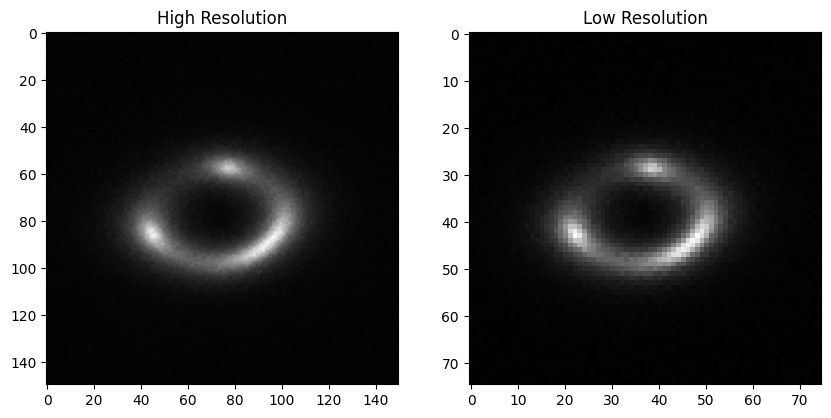

High Resolution Size:  (150, 150, 1)
Low Resolution Size:  (75, 75, 1)
High Resolution Range:  0.0 1.0
Low Resolution Range:  0.004476010581607796 0.9734353589372715


In [1]:
import os
import numpy as np




hr = "SuperRes/HR/sample1.npy"
lr = "SuperRes/LR/sample1.npy"

hr = np.load(hr)
lr = np.load(lr)
#reshaping
hr = np.transpose(hr, (1, 2, 0))
lr = np.transpose(lr, (1, 2, 0))

#plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(hr , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(lr , cmap='gray')
ax[1].set_title("Low Resolution")
plt.show()

#size
print("High Resolution Size: ", hr.shape)
print("Low Resolution Size: ", lr.shape)

#print range of pixel values
print("High Resolution Range: ", np.min(hr), np.max(hr))
print("Low Resolution Range: ", np.min(lr), np.max(lr))


In [2]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, high_res_folder, low_res_folder, highres_transform, lowres_transform, both_transforms=None):
        self.high_res_folder = high_res_folder
        self.low_res_folder = low_res_folder
        self.highres_transform = highres_transform
        self.lowres_transform = lowres_transform
        self.both_transforms = both_transforms

        self.file_names = [filename.split('.')[0] for filename in os.listdir(high_res_folder) if filename.endswith('.npy')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_folder, f"{self.file_names[idx]}.npy")
        low_res_path = os.path.join(self.low_res_folder, f"{self.file_names[idx]}.npy")

        high_res_image = np.load(high_res_path)
        low_res_image = np.load(low_res_path)
        
        high_res_image = np.transpose(high_res_image, (1, 2, 0))
        low_res_image = np.transpose(low_res_image, (1, 2, 0))


        if self.highres_transform:
            high_res_image = self.highres_transform(high_res_image)

        if self.lowres_transform:
            low_res_image = self.lowres_transform(low_res_image)

        return high_res_image, low_res_image


#sizes
high_res_folder = "SuperRes/HR"
low_res_folder = "SuperRes/LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor()])
low_res_transform = transforms.Compose([
                                        transforms.ToTensor()])

                                        

dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)
print("Number of samples: ", len(dataset))
print("Sample 0: ", dataset[0][0].shape, dataset[0][1].shape)






Number of samples:  10000
Sample 0:  torch.Size([1, 150, 150]) torch.Size([1, 75, 75])


In [4]:
import torch.nn as nn
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch


def _make_pair(value):
    if isinstance(value, int):
        value = (value,) * 2
    return value


def conv_layer(in_channels,
               out_channels,
               kernel_size,
               bias=False):
    kernel_size = _make_pair(kernel_size)
    padding = (int((kernel_size[0] - 1) / 2), 
               int((kernel_size[1] - 1) / 2))
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size,
                     padding=padding,
                     bias=bias)


def activation(act_type, inplace=True, neg_slope=0.05, n_prelu=1):
    
    act_type = act_type.lower()
    if act_type == 'relu':
        layer = nn.ReLU(inplace)
    elif act_type == 'lrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act_type == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    else:
        raise NotImplementedError(
            'activation layer [{:s}] is not found'.format(act_type))
    return layer


def sequential(*args):

    if len(args) == 1:
        if isinstance(args[0], OrderedDict):
            raise NotImplementedError(
                'sequential does not support OrderedDict input.')
        return args[0]
    modules = []
    for module in args:
        if isinstance(module, nn.Sequential):
            for submodule in module.children():
                modules.append(submodule)
        elif isinstance(module, nn.Module):
            modules.append(module)
    return nn.Sequential(*modules)


def pixelshuffle_block(in_channels,
                       out_channels,
                       upscale_factor=2,
                       kernel_size=3):
    conv = conv_layer(in_channels,
                      out_channels * (upscale_factor ** 2),
                      kernel_size)
    pixel_shuffle = nn.PixelShuffle(upscale_factor)
    return sequential(conv, pixel_shuffle)


class ESA(nn.Module):

    def __init__(self, esa_channels, n_feats, conv):
        super(ESA, self).__init__()
        f = esa_channels
        self.conv1 = conv(n_feats, f, kernel_size=1)
        self.conv_f = conv(f, f, kernel_size=1)
        self.conv2 = conv(f, f, kernel_size=3, stride=2, padding=0)
        self.conv3 = conv(f, f, kernel_size=3, padding=1)
        self.conv4 = conv(f, n_feats, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        c1_ = (self.conv1(x))
        c1 = self.conv2(c1_)
        v_max = F.max_pool2d(c1, kernel_size=7, stride=3)
        c3 = self.conv3(v_max)
        c3 = F.interpolate(c3, (x.size(2), x.size(3)),
                           mode='bilinear', align_corners=False)
        cf = self.conv_f(c1_)
        c4 = self.conv4(c3 + cf)
        m = self.sigmoid(c4)
        return x * m


class RRFB(nn.Module):
    def __init__(self,
                 in_channels,
                 mid_channels=None,
                 out_channels=None,
                 esa_channels=16):
        super(RRFB, self).__init__()

        if mid_channels is None:
            mid_channels = in_channels
        if out_channels is None:
            out_channels = in_channels

        self.c1_r = conv_layer(in_channels, mid_channels, 3)
        self.c2_r = conv_layer(mid_channels, mid_channels, 3)
        self.c3_r = conv_layer(mid_channels, in_channels, 3)

        self.c5 = conv_layer(in_channels, out_channels, 1)
        self.esa = ESA(esa_channels, out_channels, nn.Conv2d)

        self.act = activation('lrelu', neg_slope=0.05)

    def forward(self, x):
        out_33 = (self.c1_r(x))
        out = self.act(out_33)

        out_33 = (self.c2_r(out))
        out = self.act(out_33)

        out_33 = (self.c3_r(out))
        out = self.act(out_33)

        out = out + x
        out = self.esa(self.c5(out))

        return out


def make_model(args, parent=False):
    model = DIPNet()
    return model


class DIPNet(nn.Module):

    def __init__(self,
                 in_channels=3,
                 out_channels=3,
                 feature_channels=44,
                 upscale=4):
        super(DIPNet, self).__init__()

        self.conv_1 = conv_layer(in_channels,
                                       feature_channels,
                                       kernel_size=3)

        self.block_1 = RRFB(feature_channels, mid_channels=38)
        self.block_2 = RRFB(feature_channels, mid_channels=38)
        self.block_3 = RRFB(feature_channels, mid_channels=38)
        self.block_4 = RRFB(feature_channels, mid_channels=38)

        self.conv_2 = conv_layer(feature_channels,
                                   feature_channels,
                                   kernel_size=3)

        self.upsampler = pixelshuffle_block(feature_channels,
                                          out_channels,
                                          upscale_factor=upscale)

    def forward(self, x):
        out_feature = self.conv_1(x)

        out_b1 = self.block_1(out_feature)
        out_b2 = self.block_2(out_b1)
        out_b3 = self.block_3(out_b2)
        out_b4 = self.block_4(out_b3)


        out_low_resolution = self.conv_2(out_b4) + out_feature
        output = self.upsampler(out_low_resolution)

        return output

In [5]:
#Training DIPNet
import torch
import torch.nn as nn
from alive_progress import alive_bar

class DIPNetTrainer:
    def __init__(self, model, train_loader, val_loader, lr=1e-4, epochs=10, device="cuda"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.epochs = epochs
        self.device = device

        self.model.to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            best_val_loss = 1

            with alive_bar(len(self.train_loader) , force_tty = True) as bar:
                for i, data in enumerate(self.train_loader):
                    high_res, low_res = data
                    high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                    self.optimizer.zero_grad()
                    outputs = self.model(low_res)
                    loss = self.criterion(outputs, high_res)
                    loss.backward()
                    self.optimizer.step()

                    train_loss += loss.item()
                    bar()

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {train_loss/len(self.train_loader)}")
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                with alive_bar(len(self.val_loader) , force_tty = True) as bar:
                    for i, data in enumerate(self.val_loader):
                        high_res, low_res = data
                        high_res, low_res = high_res.to(self.device , dtype=torch.float), low_res.to(self.device , dtype=torch.float)

                        outputs = self.model(low_res)
                        loss = self.criterion(outputs, high_res)

                        val_loss += loss.item()
                        bar()

                print(f"Validation Loss: {val_loss/len(self.val_loader)}")
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_model("best_model_Superres.pth")     

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))

    def predict(self, low_res):
        self.model.eval()
        with torch.no_grad():
            low_res = low_res.to(self.device)
            output = self.model(low_res)
        return output
    
#Training
high_res_folder = "SuperRes/HR"
low_res_folder = "SuperRes/LR"

high_res_transform = transforms.Compose([
                                        transforms.ToTensor()])

low_res_transform = transforms.Compose([
                                        transforms.ToTensor()])
dataset = CustomDataset(high_res_folder, low_res_folder, high_res_transform, low_res_transform)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = DIPNet(in_channels=1, out_channels=1, feature_channels=44, upscale=2)

trainer = DIPNetTrainer(model, train_loader, val_loader, lr=1e-4, epochs=50, device="cuda")


#sample model input
low_res = torch.rand(1, 1, 75, 75)
output = trainer.predict(low_res)
print("Output Size: ", output.shape)

Output Size:  torch.Size([1, 1, 150, 150])


In [75]:
#training
trainer.train()

|████████████████████████████████████████| 2000/2000 [100%] in 38.8s (51.62/s)  
Epoch 1/50, Loss: 0.0002354326966087683
|████████████████████████████████████████| 500/500 [100%] in 3.0s (167.12/s)    
Validation Loss: 6.794218168943189e-05
|████████████████████████████████████████| 2000/2000 [100%] in 39.6s (50.53/s)  
Epoch 2/50, Loss: 6.326089137110102e-05
|████████████████████████████████████████| 500/500 [100%] in 3.1s (163.86/s)    
Validation Loss: 6.045172691665357e-05
|████████████████████████████████████████| 2000/2000 [100%] in 38.7s (51.65/s)  
Epoch 3/50, Loss: 5.965987599665823e-05
|████████████████████████████████████████| 500/500 [100%] in 3.2s (156.35/s)    
Validation Loss: 5.935183919064002e-05
|████████████████████████████████████████| 2000/2000 [100%] in 39.3s (50.89/s)  
Epoch 4/50, Loss: 5.9113883376994636e-05
|████████████████████████████████████████| 500/500 [100%] in 3.4s (149.30/s)    
Validation Loss: 5.887807589169825e-05
|██████████████████████████████████

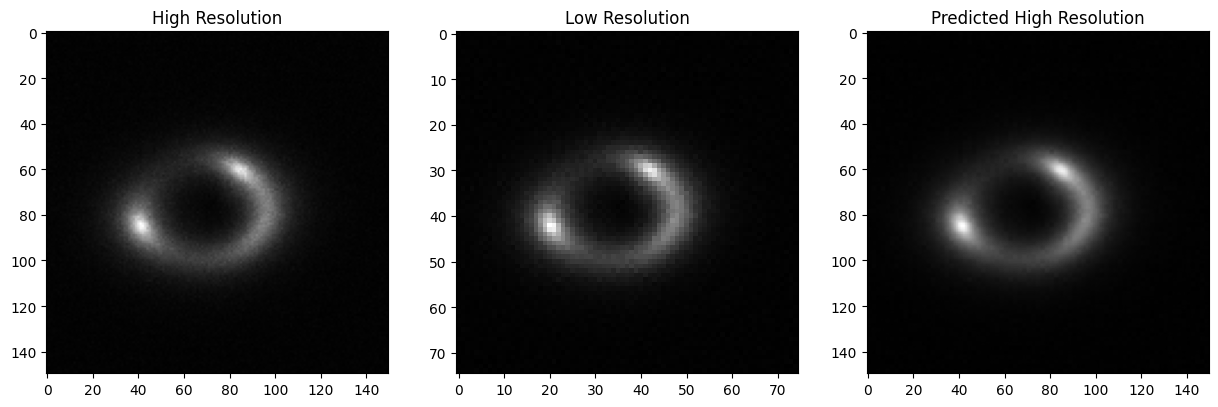

In [9]:
import matplotlib.pyplot as plt
model.load_state_dict(torch.load("best_model_Superres.pth"))

high_res, low_res = val_dataset[0]
low_res = low_res.unsqueeze(0)
low_res = low_res.to(torch.float)
output = trainer.predict(low_res)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(high_res.squeeze(0).squeeze(0) , cmap='gray')
ax[0].set_title("High Resolution")
ax[1].imshow(low_res.squeeze(0).squeeze(0) , cmap='gray')
ax[1].set_title("Low Resolution")
ax[2].imshow(output.cpu().squeeze(0).squeeze(0) , cmap='gray')
ax[2].set_title("Predicted High Resolution")
plt.show()

In [79]:
# MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def psnr(y_true, y_pred):
    return peak_signal_noise_ratio(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

def ssim_score(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=y_pred.max() - y_pred.min())

metrics = {'MSE': [], 'PSNR': [], 'SSIM': []}

model.load_state_dict(torch.load("best_model_Superres.pth"))

with alive_bar(len(val_dataset) , force_tty = True) as bar:
    for i in range(len(val_dataset)):
        high_res, low_res = val_dataset[i]
        low_res = low_res.unsqueeze(0)
        low_res = low_res.to(torch.float)
        output = trainer.predict(low_res)

        high_res = high_res.squeeze(0).squeeze(0).numpy()
        output = output.cpu().squeeze(0).squeeze(0).numpy()
        low_res = low_res.squeeze(0).squeeze(0).numpy()

        metrics['MSE'].append(mse(high_res, output))
        metrics['PSNR'].append(psnr(high_res, output))
        metrics['SSIM'].append(ssim_score(high_res, output))
        bar()

average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
average_metrics


|████████████████████████████████████████| 2000/2000 [100%] in 10.1s (197.99/s) 


{'MSE': 5.846322436030497e-05,
 'PSNR': 42.367233424877604,
 'SSIM': 0.9767148031742621}

In [80]:
#on training data
metrics = {'MSE': [], 'PSNR': [], 'SSIM': []}

with alive_bar(len(train_dataset) , force_tty = True) as bar:
    for i in range(len(train_dataset)):
        high_res, low_res = train_dataset[i]
        low_res = low_res.unsqueeze(0)
        low_res = low_res.to(torch.float)
        output = trainer.predict(low_res)

        high_res = high_res.squeeze(0).squeeze(0).numpy()
        output = output.cpu().squeeze(0).squeeze(0).numpy()
        low_res = low_res.squeeze(0).squeeze(0).numpy()

        metrics['MSE'].append(mse(high_res, output))
        metrics['PSNR'].append(psnr(high_res, output))
        metrics['SSIM'].append(ssim_score(high_res, output))
        bar()

average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
average_metrics

|████████████████████████████████████████| 8000/8000 [100%] in 41.4s (193.39/s) 


{'MSE': 5.848699887193077e-05,
 'PSNR': 42.36468788081218,
 'SSIM': 0.9767118159179558}

In [ ]:
# #ESRGAN
# import torch
# from torch import nn


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, use_act, **kwargs):
#         super().__init__()
#         self.cnn = nn.Conv2d(
#             in_channels,
#             out_channels,
#             **kwargs,
#             bias=True,
#         )
#         self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

#     def forward(self, x):
#         return self.act(self.cnn(x))


# class UpsampleBlock(nn.Module):
#     def __init__(self, in_c, scale_factor=2):
#         super().__init__()
#         self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
#         self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
#         self.act = nn.LeakyReLU(0.2, inplace=True)

#     def forward(self, x):
#         return self.act(self.conv(self.upsample(x)))


# class DenseResidualBlock(nn.Module):
#     def __init__(self, in_channels, channels=32, residual_beta=0.2):
#         super().__init__()
#         self.residual_beta = residual_beta
#         self.blocks = nn.ModuleList()

#         for i in range(5):
#             self.blocks.append(
#                 ConvBlock(
#                     in_channels + channels * i,
#                     channels if i <= 3 else in_channels,
#                     kernel_size=3,
#                     stride=1,
#                     padding=1,
#                     use_act=True if i <= 3 else False,
#                 )
#             )

#     def forward(self, x):
#         new_inputs = x
#         for block in self.blocks:
#             out = block(new_inputs)
#             new_inputs = torch.cat([new_inputs, out], dim=1)
#         return self.residual_beta * out + x


# class RRDB(nn.Module):
#     def __init__(self, in_channels, residual_beta=0.2):
#         super().__init__()
#         self.residual_beta = residual_beta
#         self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

#     def forward(self, x):
#         return self.rrdb(x) * self.residual_beta + x


# class Generator(nn.Module):
#     def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
#         super().__init__()
#         self.initial = nn.Conv2d(
#             in_channels,
#             num_channels,
#             kernel_size=3,
#             stride=1,
#             padding=1,
#             bias=True,
#         )
#         self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
#         self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
#         self.upsamples = nn.Sequential(
#             UpsampleBlock(num_channels), UpsampleBlock(num_channels),
#         )
#         self.final = nn.Sequential(
#             nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
#         )

#     def forward(self, x):
#         initial = self.initial(x)
#         x = self.conv(self.residuals(initial)) + initial
#         x = self.upsamples(x)
#         return self.final(x)


# class Discriminator(nn.Module):
#     def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
#         super().__init__()
#         blocks = []
#         for idx, feature in enumerate(features):
#             blocks.append(
#                 ConvBlock(
#                     in_channels,
#                     feature,
#                     kernel_size=3,
#                     stride=1 + idx % 2,
#                     padding=1,
#                     use_act=True,
#                 ),
#             )
#             in_channels = feature

#         self.blocks = nn.Sequential(*blocks)
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((6, 6)),
#             nn.Flatten(),
#             nn.Linear(512 * 6 * 6, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 1),
#         )

#     def forward(self, x):
#         x = self.blocks(x)
#         return self.classifier(x)

# def initialize_weights(model, scale=0.1):
#     for m in model.modules():
#         if isinstance(m, nn.Conv2d):
#             nn.init.kaiming_normal_(m.weight.data)
#             m.weight.data *= scale

#         elif isinstance(m, nn.Linear):
#             nn.init.kaiming_normal_(m.weight.data)
#             m.weight.data *= scale






